In [43]:
import click
import numpy as np
from scipy import stats
from math import ceil
import h5py
from copy import deepcopy
from optimize_dynamic_model import analyze_slice, get_binary_input_patterns
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from generate_figures import import_slice_data, import_dynamic_activity, plot_cumulative_sparsity, plot_cumulative_selectivity, plot_cumulative_discriminability

In [44]:
data_file_path='data/20240220_144648_exported_model_data.hdf5'

In [45]:
dynamics_file_path='data/20240220_144648_exported_model_data_dynamics.hdf5'

In [46]:
model_seed='1234'

In [47]:
    _,num_units_history_dict,_,_,weight_history_dict, network_activity_history_dict, sparsity_history_dict, \
        similarity_matrix_history_dict, selectivity_history_dict,fraction_active_patterns_history_dict,\
        _ = import_slice_data(data_file_path)
    network_activity_dynamics_history_dict =  import_dynamic_activity(dynamics_file_path)

In [48]:
color_dict={'log_normal_init_no_learning_FF_Inh+indirect_FB_Inh' : 'k', 'uniform_init_no_learning_FF_Inh+indirect_FB_Inh' : 'cyan'}

In [49]:
label_dict={'log_normal_init_no_learning_FF_Inh+indirect_FB_Inh' : 'log normal weights no learning', 'uniform_init_no_learning_FF_Inh+indirect_FB_Inh' : 'uniform weights no learning'}

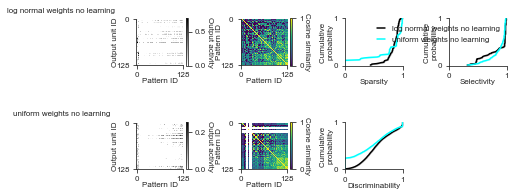

In [50]:

mm = 1 / 25.4  # millimeters to inches
fig = plt.figure(figsize=(180 * mm, 120 * mm))
axes = gs.GridSpec(nrows=3, ncols=5,
                   left=0.05,right=0.98,
                   top = 0.95, bottom = 0.2,
                   wspace=0.8, hspace=1.2)


fontsize = 8
description_list = ['log_normal_init_no_learning_FF_Inh+indirect_FB_Inh', 'uniform_init_no_learning_FF_Inh+indirect_FB_Inh']

# Model diagrams & titles
for i,description in enumerate(description_list):
    ax = fig.add_subplot(axes[i, 0])
    ax.axis('off')
    ax.set_title(label_dict[description], fontsize=fontsize)

# Output activity for FF, FB, FF+FB
num_output_units = num_units_history_dict['log_normal_init_no_learning_FF_Inh+indirect_FB_Inh'][model_seed]['Output']
for i,description in enumerate(description_list):
    ax = fig.add_subplot(axes[i, 1])
    output_activity = network_activity_history_dict[description][model_seed]['Output']
    argmax_indices = np.argmax(output_activity, axis=0)
    sorted_indices = np.argsort(argmax_indices)
    im = ax.imshow(output_activity[:, sorted_indices].transpose(), aspect='equal', cmap='binary',interpolation="nearest")
    ax.set_xticks([0, num_output_units])
    ax.set_yticks([0, num_output_units])
    ax.set_xlabel('Pattern ID',fontsize=fontsize,labelpad=0)
    ax.set_ylabel('Output unit ID',fontsize=fontsize,labelpad=-2)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Output activity', rotation=270, labelpad=7, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

#Similarity matrix
num_patterns = 2**num_units_history_dict['log_normal_init_no_learning_FF_Inh+indirect_FB_Inh'][model_seed]['Input']
for i,description in enumerate(description_list):
    ax = fig.add_subplot(axes[i, 2])
    similarity_matrix = similarity_matrix_history_dict[description][model_seed]['Output']
    im = ax.imshow(similarity_matrix, aspect='equal', cmap='viridis',vmin=0, vmax=1,interpolation="nearest")
    ax.set_xticks([0, num_output_units])
    ax.set_yticks([0, num_output_units])
    ax.set_xlabel('Pattern ID',fontsize=fontsize,labelpad=0)
    ax.set_ylabel('Pattern ID',fontsize=fontsize ,labelpad=-2)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
    cbar.set_label('Cosine similarity', rotation=270, labelpad=7, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

#Cumulative distribution for sparsity (1 - fraction active)
description_list = ['log_normal_init_no_learning_FF_Inh+indirect_FB_Inh', 'uniform_init_no_learning_FF_Inh+indirect_FB_Inh']

ax = fig.add_subplot(axes[0, 3])
cumulative_sparsity_dict = {}
for description in description_list:
    cumulative_sparsity, mean_sparsity, cdf_prob_bins, SD = plot_cumulative_sparsity(sparsity_history_dict[description])
    cumulative_sparsity_dict[description] = cumulative_sparsity
    ax.plot(mean_sparsity, cdf_prob_bins, label=label_dict[description],color=color_dict[description])
    error_min = mean_sparsity - SD
    error_max = mean_sparsity + SD
    ax.fill_betweenx(cdf_prob_bins, error_min, error_max, alpha=0.2,color=color_dict[description])
ax.tick_params(labelsize=fontsize)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel('Sparsity',fontsize=fontsize,labelpad=0)
ax.set_ylabel('Cumulative \nprobability',fontsize=fontsize,labelpad=0)

# s, p1 = stats.ks_2samp(cumulative_sparsity_dict['Input-Output-lognormal'],
#                       cumulative_sparsity_dict['FF_Inh'])
# s, p2 = stats.ks_2samp(cumulative_sparsity_dict['Input-Output-lognormal'],
#                       cumulative_sparsity_dict['FF_Inh_no_sel_loss'])
# s, p3 = stats.ks_2samp(cumulative_sparsity_dict['FF_Inh'],
#                       cumulative_sparsity_dict['FF_Inh_no_sel_loss'])
# median_lognormal = np.median(cumulative_sparsity_dict['Input-Output-lognormal'])
# median_FFinh = np.median(cumulative_sparsity_dict['FF_Inh'])
# median_FFinh_NoSel = np.median(cumulative_sparsity_dict['FF_Inh_no_sel_loss'])
# path_to_file = 'ks_tests.txt'
# mode = 'a' if os.path.exists(path_to_file) else 'w'
# with open(path_to_file, mode) as f:
#     f.write("\nFig3 Sparsity Stats:"
#             f"\nMedian - lognormal{median_lognormal}; FF Inh: {median_FFinh}; No selectivity:{median_FFinh_NoSel}"
#             f"\nLognormal Vs FF Inh: p = {p1}"
#             f"\nLognormal Vs FF No selectivity: p = {p2}"
#             f"\nFF Inh Vs FF No selectivity: p = {p3}")

#Cumulative distribution for selectivity
ax = fig.add_subplot(axes[0, 4])
cumulative_selectivity_dict = {}
for description in description_list:
    cumulative_selectivity, mean_selectivity, cdf_prob_bins, SD = plot_cumulative_selectivity(selectivity_history_dict[description])
    cumulative_selectivity_dict[description] = cumulative_selectivity
    ax.plot(mean_selectivity, cdf_prob_bins, label=label_dict[description],color=color_dict[description])
    error_min = mean_selectivity - SD
    error_max = mean_selectivity + SD
    ax.fill_betweenx(cdf_prob_bins, error_min, error_max,alpha=0.2,color=color_dict[description])
ax.tick_params(labelsize=fontsize)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel('Selectivity',fontsize=fontsize,labelpad=0)
ax.set_ylabel('Cumulative \nprobability',fontsize=fontsize,labelpad=0)
ax.legend(loc='best',frameon=False,fontsize=fontsize,handlelength=1)

# s, p1 = stats.ks_2samp(cumulative_selectivity_dict['Input-Output-lognormal'],
#                       cumulative_selectivity_dict['FF_Inh'])
# s, p2 = stats.ks_2samp(cumulative_selectivity_dict['Input-Output-lognormal'],
#                       cumulative_selectivity_dict['FF_Inh_no_sel_loss'])
# s, p3 = stats.ks_2samp(cumulative_selectivity_dict['FF_Inh'],
#                       cumulative_selectivity_dict['FF_Inh_no_sel_loss'])
# with open(path_to_file, 'a') as f:
#     f.write("\nFig3 Selectivity Stats:"
#             f"\nLognormal Vs FF Inh: p = {p1}"
#             f"\nLognormal Vs FF No selectivity: p = {p2}"
#             f"\nFF Inh Vs FF No selectivity: p = {p3}")

#Cumulative distribution for discriminability
ax = fig.add_subplot(axes[1, 3])
cumulative_discriminability_dict = {}
for description in description_list:
    cumulative_discriminability, mean_discriminability, cdf_prob_bins, SD = plot_cumulative_discriminability(similarity_matrix_history_dict[description])
    cumulative_discriminability_dict[description] = cumulative_discriminability
    ax.plot(mean_discriminability, cdf_prob_bins, label=label_dict[description],color=color_dict[description])
    error_min = mean_discriminability - SD
    error_max = mean_discriminability + SD
    ax.fill_betweenx(cdf_prob_bins, error_min, error_max,alpha=0.2,color=color_dict[description])
ax.tick_params(labelsize=fontsize)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel('Discriminability',fontsize=fontsize,labelpad=0)
ax.set_ylabel('Cumulative \nprobability',fontsize=fontsize,labelpad=0)


# s, p1 = stats.ks_2samp(cumulative_discriminability_dict['Input-Output-lognormal'],
#                       cumulative_discriminability_dict['FF_Inh'])
# s, p2 = stats.ks_2samp(cumulative_discriminability_dict['Input-Output-lognormal'],
#                       cumulative_discriminability_dict['FF_Inh_no_sel_loss'])
# s, p3 = stats.ks_2samp(cumulative_discriminability_dict['FF_Inh'],
#                       cumulative_discriminability_dict['FF_Inh_no_sel_loss'])
# with open(path_to_file, 'a') as f:
#     f.write("\nFig3 Discriminability Stats:"
#             f"\nLognormal Vs FF Inh: p = {p1}"
#             f"\nLognormal Vs FF No selectivity: p = {p2}"
#             f"\nFF Inh Vs FF No selectivity: p = {p3}\n")



sns.despine()
# fig.savefig('figures/Figure3.svg', edgecolor='white', dpi=300, facecolor='white', transparent=True)
# fig.savefig('figures/Figure3.png', edgecolor='white', dpi=300, facecolor='white', transparent=True)
